In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_profiling
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [20]:
#Print multiple statements in same line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [21]:
flightdata=pd.read_csv('flightdata.csv')

In [22]:
report = pandas_profiling.ProfileReport(flightdata)
#covert profile report as html file
report.to_file("flight_data.html")

In [23]:
flightdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
year              336776 non-null int64
month             336776 non-null int64
day               336776 non-null int64
dep_time          328521 non-null float64
sched_dep_time    336776 non-null int64
dep_delay         328521 non-null float64
arr_time          328063 non-null float64
sched_arr_time    336776 non-null int64
arr_delay         327346 non-null float64
carrier           336776 non-null object
flight            336776 non-null int64
tailnum           334264 non-null object
origin            336776 non-null object
dest              336776 non-null object
air_time          327346 non-null float64
distance          336776 non-null int64
hour              336776 non-null int64
minute            336776 non-null int64
time_hour         336776 non-null object
dtypes: float64(5), int64(9), object(5)
memory usage: 48.8+ MB


Dropping column 'tailnum' as it is not making any difference in departure/delay of the flights

In [24]:
flightdata.drop(['tailnum'],axis=1,inplace=True)

Data Wrangling

Replacing missing value of dep_delay with the median of dep_delay

In [25]:
flightdata['dep_delay'].fillna(flightdata['dep_delay'].median(),inplace=True)

Updating missing value of actual dep_time by combining scheduled departure hour and minute + dep_delay

In [26]:
def cal_dep1_time(scheddeptime_delay):
    scheddeptime,delay = scheddeptime_delay
    hour,minute = divmod(scheddeptime,100)
    totalSecs = (hour * 60 + minute + delay) * 60
    totalSecs, sec = divmod(totalSecs, 60)
    hr, min = divmod(totalSecs, 60)
    return float("%d%02d" % (hr, min))

flightdata['dep_time'] = flightdata[['sched_dep_time','dep_delay']].apply(cal_dep1_time, axis=1)

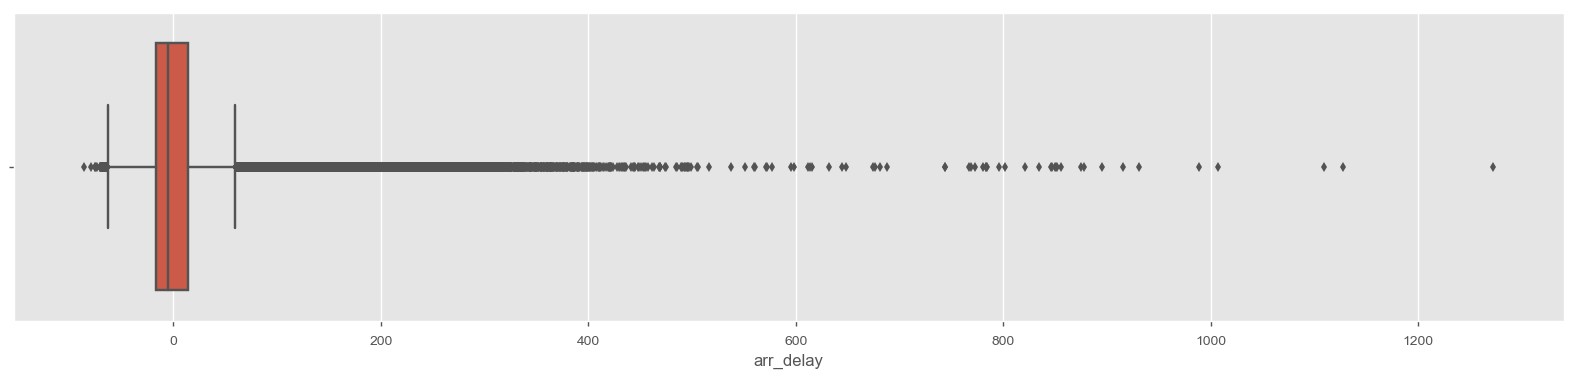

In [28]:
#Finding the median of arr_delay using box plot, also checking outliers
from matplotlib import style
style.use('ggplot')
plt.figure(figsize=(20,4))
sns.boxplot(x='arr_delay',data=flightdata)
plt.show();

In [29]:
flightdata.describe()['arr_delay']

count    327346.000000
mean          6.895377
std          44.633292
min         -86.000000
25%         -17.000000
50%          -5.000000
75%          14.000000
max        1272.000000
Name: arr_delay, dtype: float64

Updating missing value of arr_delay by using difference between actual arrival time and scheduled arrival time

In [31]:
def cal_delay(time_schtime):
    time,schtime = time_schtime
    actime,acminute = divmod(time,100)
    sctime,scminute = divmod(schtime,100)
    totalSecs = (actime * 60 + acminute) * 60 - (sctime * 60 + scminute) * 60
    return totalSecs/60
#else:
flightdata['arr_delay'] = flightdata[flightdata['arr_time'].notnull()][['arr_time','sched_arr_time']].apply(cal_delay, axis=1)

Replacing rest of the missing value of arr_delay with median of arr_delay

In [32]:
flightdata['arr_delay'].fillna(flightdata['arr_delay'].median(),inplace=True)

Updating missing value of arr_time by combining scheduled arrival hour and minute + arr_delay

In [33]:
flightdata.iloc[754,:]

year                          2013
month                            1
day                              1
dep_time                      2016
sched_dep_time                1930
dep_delay                       46
arr_time                       NaN
sched_arr_time                2220
arr_delay                       -6
carrier                         EV
flight                        4204
origin                         EWR
dest                           OKC
air_time                       NaN
distance                      1325
hour                            19
minute                          30
time_hour         01-01-2013 19:00
Name: 754, dtype: object

In [34]:
flightdata['arr_time'] = flightdata[['sched_arr_time','arr_delay']].apply(cal_dep1_time, axis=1)

In [35]:
flightdata['air_time'].describe()

count    327346.000000
mean        150.686460
std          93.688305
min          20.000000
25%          82.000000
50%         129.000000
75%         192.000000
max         695.000000
Name: air_time, dtype: float64

Replacing missing value of air_time with median & groupby, flight and carrier wise

In [36]:
by_flight_carrier=flightdata.groupby(['flight','carrier'])
by_flight_carrier['air_time'].median()

flight  carrier
1       AA         326.0
        B6         151.0
        DL         191.5
        UA         142.0
        WN         111.5
2       B6          56.0
        WN         131.0
3       AA         326.0
        B6         199.0
        UA         184.5
        WN         127.0
4       B6          57.0
        DL         155.0
5       AS         324.0
        B6         147.0
6       B6          57.0
        DL         274.5
7       AS         326.0
        WN         238.0
8       B6          54.0
9       B6         137.0
10      B6          57.0
        UA         208.5
11      AS         334.0
        B6         150.5
        VX         348.0
12      B6          47.0
        UA         291.0
15      AS         320.0
        B6         315.0
                   ...  
6047    EV          64.0
6049    EV          46.0
6054    EV          44.0
6055    EV          51.0
6062    EV          24.5
6065    EV          95.0
6067    EV          92.0
6068    EV          75.5
6069    E

In [37]:
def impute_median(series):
    return series.fillna(series.median())
flightdata['air_time']=by_flight_carrier['air_time'].transform(impute_median)

In [38]:
flightdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 18 columns):
year              336776 non-null int64
month             336776 non-null int64
day               336776 non-null int64
dep_time          336776 non-null float64
sched_dep_time    336776 non-null int64
dep_delay         336776 non-null float64
arr_time          336776 non-null float64
sched_arr_time    336776 non-null int64
arr_delay         336776 non-null float64
carrier           336776 non-null object
flight            336776 non-null int64
origin            336776 non-null object
dest              336776 non-null object
air_time          336757 non-null float64
distance          336776 non-null int64
hour              336776 non-null int64
minute            336776 non-null int64
time_hour         336776 non-null object
dtypes: float64(5), int64(9), object(4)
memory usage: 46.2+ MB


Dropping airtime missing values rows as they are single records

In [39]:
flightdata[flightdata['air_time'].isnull()].index.tolist()

[1650,
 42937,
 105229,
 110509,
 127940,
 144295,
 144351,
 144517,
 144518,
 144519,
 203583,
 250396,
 251340,
 251353,
 275945,
 282337,
 308714,
 310127,
 310786]

In [40]:
flightdata.drop(flightdata[flightdata['air_time'].isnull()].index.tolist(),inplace=True)

In [41]:
flightdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336757 entries, 0 to 336775
Data columns (total 18 columns):
year              336757 non-null int64
month             336757 non-null int64
day               336757 non-null int64
dep_time          336757 non-null float64
sched_dep_time    336757 non-null int64
dep_delay         336757 non-null float64
arr_time          336757 non-null float64
sched_arr_time    336757 non-null int64
arr_delay         336757 non-null float64
carrier           336757 non-null object
flight            336757 non-null int64
origin            336757 non-null object
dest              336757 non-null object
air_time          336757 non-null float64
distance          336757 non-null int64
hour              336757 non-null int64
minute            336757 non-null int64
time_hour         336757 non-null object
dtypes: float64(5), int64(9), object(4)
memory usage: 48.8+ MB


In [42]:
f = flightdata['carrier'].groupby(flightdata['carrier']).count()
f.sort_values(ascending = False)

carrier
UA    58664
B6    54635
EV    54168
DL    48110
AA    32729
MQ    26397
US    20535
9E    18454
WN    12269
VX     5162
FL     3260
AS      714
F9      685
YV      601
HA      342
OO       32
Name: carrier, dtype: int64

Creating a new column for arrival and departure delay as 1 or 0 if delay is more than 15 mins

In [43]:
def convert_delay(delay):
    if(delay>=15):
        delay=1
    else:
        delay=0
    return delay

flightdata['dep_del15']=flightdata['dep_delay'].apply(convert_delay)
flightdata['arr_del15']=flightdata['arr_delay'].apply(convert_delay)

Creating a new column for arrival and departure delay with actual delay if more than 0

In [44]:
def convert_diff(delay):
    if(delay<0):
        delay=0
    return delay

flightdata['dep_del_new']=flightdata['dep_delay'].apply(convert_diff)
flightdata['arr_del_new']=flightdata['dep_delay'].apply(convert_diff)

In [45]:
flightdata.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dest,air_time,distance,hour,minute,time_hour,dep_del15,arr_del15,dep_del_new,arr_del_new
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,IAH,227.0,1400,5,15,01-01-2013 05:00,0,0,2.0,2.0
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,IAH,227.0,1416,5,29,01-01-2013 05:00,0,1,4.0,4.0
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,MIA,160.0,1089,5,40,01-01-2013 05:00,0,1,2.0,2.0
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,BQN,183.0,1576,5,45,01-01-2013 05:00,0,0,0.0,0.0
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,ATL,116.0,762,6,0,01-01-2013 06:00,0,0,0.0,0.0


Exploratory Data Analysis

In [46]:
#Calculating total % of dep_delay from 3 airports in 2013/total number of flights 
pct_flight_del = flightdata.dep_del15.value_counts()/len(flightdata)
pct_flight_del

0    0.783485
1    0.216515
Name: dep_del15, dtype: float64

In [47]:
flightdata.arr_del15.value_counts()/len(flightdata)

0    0.776076
1    0.223924
Name: arr_del15, dtype: float64

In [48]:
#We can see that almost 1/4th of the flights have delay in departure from 3 different airports in 2013
flightdata.arr_del15.value_counts()/len(flightdata)

0    0.776076
1    0.223924
Name: arr_del15, dtype: float64

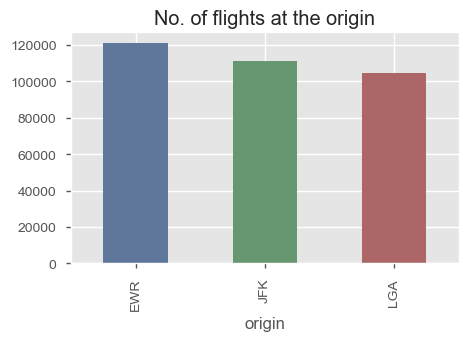

In [61]:
departure_Origin_counts = flightdata['dep_del15'].groupby(flightdata['origin']).count()
departure_Origin_counts
plt.figure(figsize=(5,3))
departure_Origin_counts.sort_values(ascending=False).plot(kind='bar', title='No. of flights at the origin')
plt.show();

In [53]:
departure_delay_counts = flightdata['dep_del15'].groupby(flightdata['origin']).sum()
arrival_delay_counts = flightdata['arr_del15'].groupby(flightdata['dest']).sum()
#arrival_delay_counts.sort_values(ascending =False)
departure_delay_counts

origin
EWR    29775
JFK    23347
LGA    19791
Name: dep_del15, dtype: int64

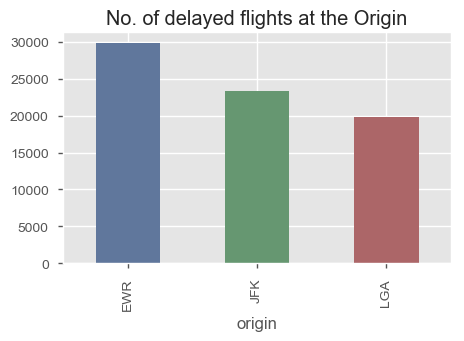

In [60]:
#Showing count of flight delays at each orgin airport
sns.set_palette("deep",desat=.6)
colors= sns.color_palette("deep")
plt.figure(figsize=(5,3))
departure_delay_counts.sort_values(ascending=False).plot(kind='bar', title='No. of delayed flights at the Origin')
plt.show();

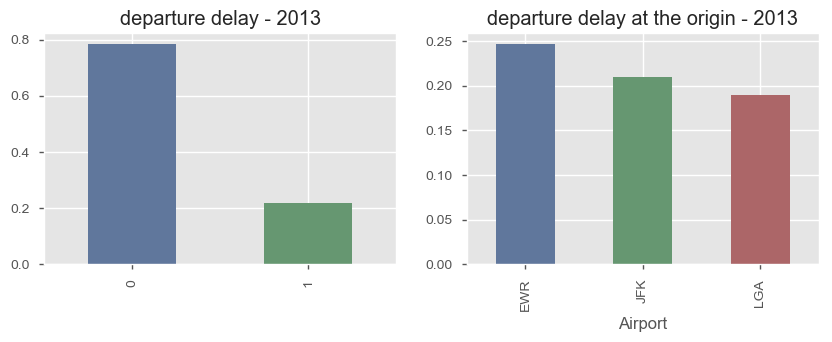

In [64]:
# % wise calculation of origin and destination airport where departure delay is maximum

pct_departure_delay = departure_delay_counts / flightdata.origin.value_counts()
pct_arrival_delay = arrival_delay_counts / flightdata.dest.value_counts()

#We can see that Newark airport has nearly 25% of departure delay out of its total flight

plt.figure(figsize=(10,3))
plt.subplot(121)

pct_flight_del.sort_values(ascending=False).plot(kind='bar', title='departure delay - 2013')
plt.subplot(122)
pct_departure_delay.sort_values(ascending=False).plot(kind='bar', title='departure delay at the origin - 2013')
plt.xlabel('Airport')
plt.show();

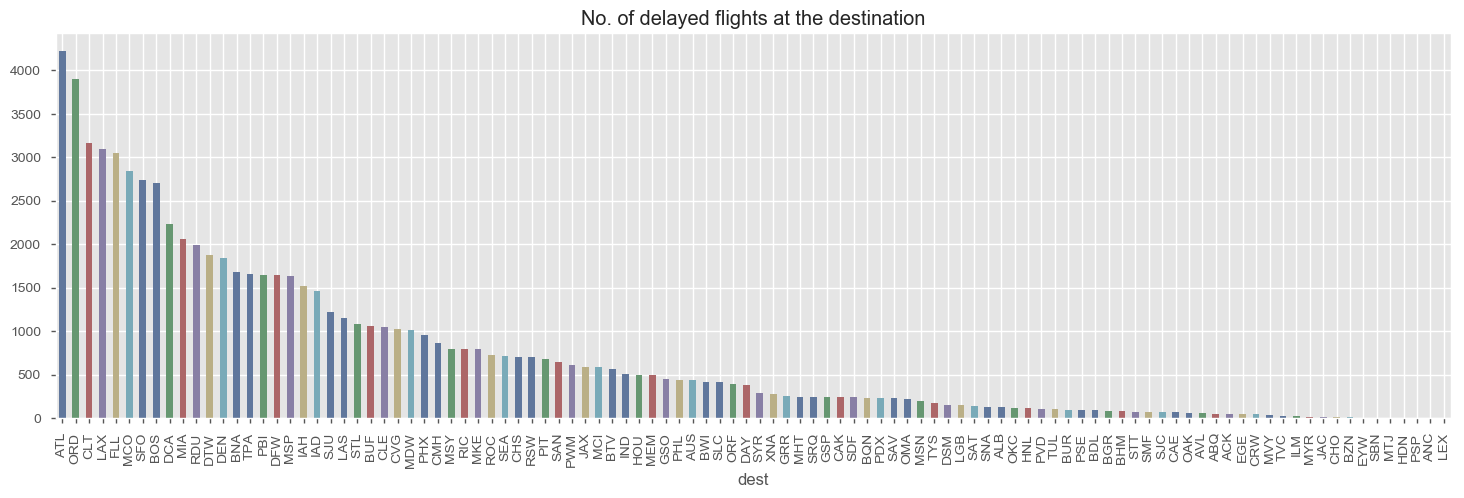

In [63]:
#Showcasing no. of flight delay at each dest airport
sns.set_palette("deep",desat=.6)
colors= sns.color_palette("deep")
plt.figure(figsize=(18,5))
arrival_delay_counts.sort_values(ascending=False).plot(kind='bar', title='No. of delayed flights at the destination')
plt.show();

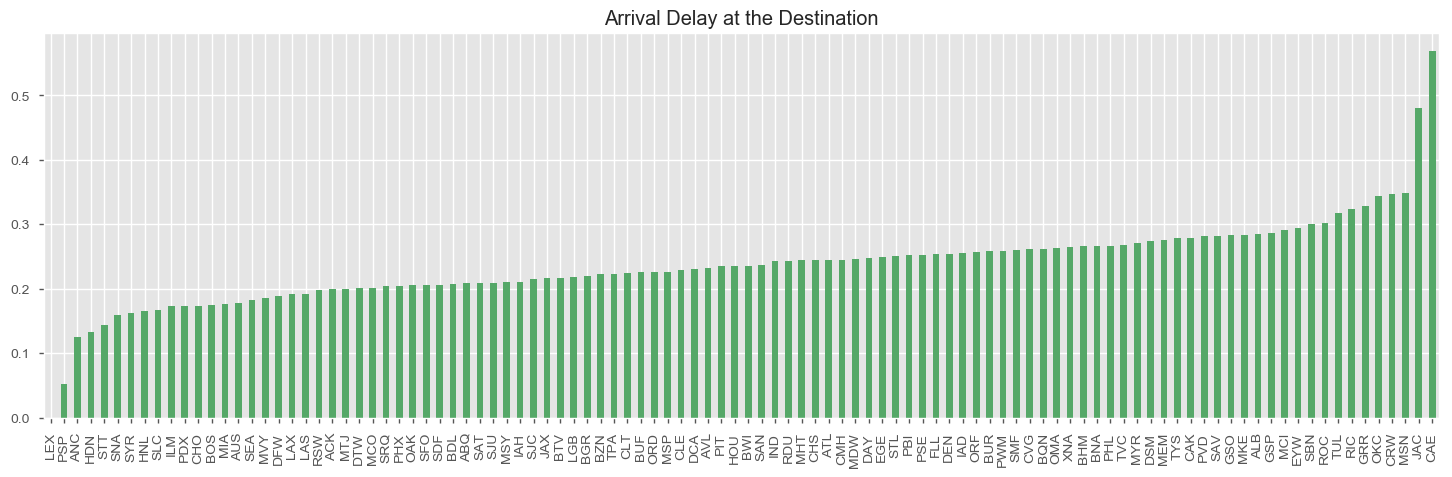

In [66]:
# % wise calculation of destination airport where arrival delay is maximum
sns.set_palette("deep",desat=.6)
colors= sns.color_palette("deep")
plt.figure(figsize=(18,5))
pct_arrival_delay.sort_values(ascending=True).plot(kind='bar', color=colors[1], title='Arrival Delay at the Destination')
plt.show();

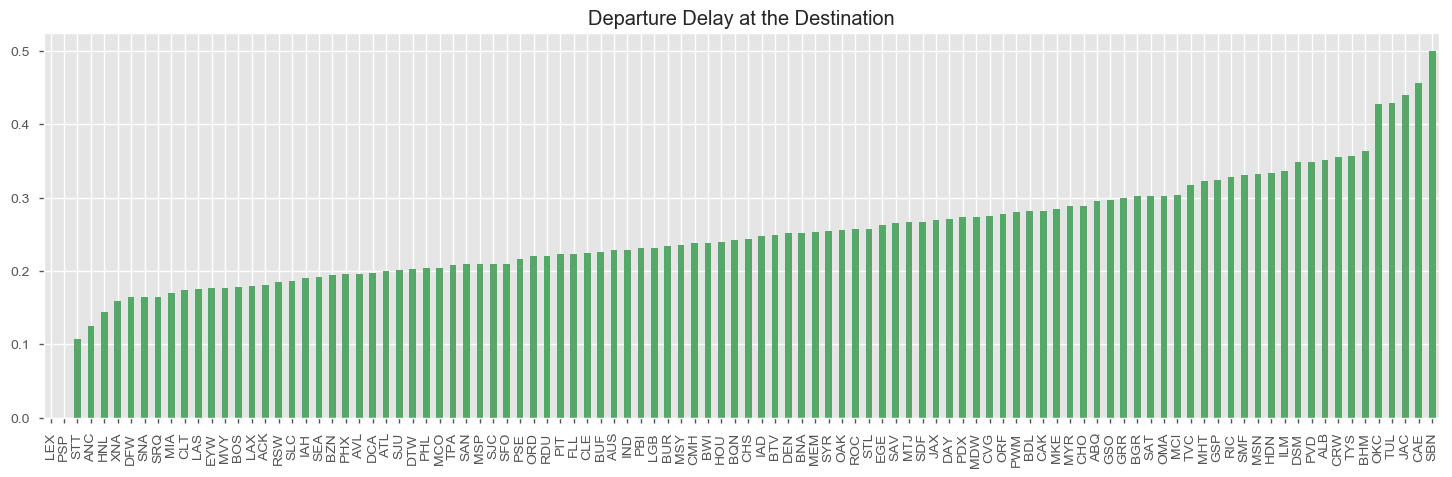

In [67]:
arrival_delay_counts1 = flightdata['dep_del15'].groupby(flightdata['dest']).sum()
pct_arrival_delay1 = arrival_delay_counts1 / flightdata.dest.value_counts()
plt.figure(figsize=(18,5))
pct_arrival_delay1.sort_values(ascending=True).plot(kind='bar', color=colors[1], title='Departure Delay at the Destination')
plt.show();

Analysis of specific carrier/airline leading to arrival or departure delay from the origin & destination

In [68]:
# % wise calculation of carriers from total no. of flights
departure_carrier_counts = flightdata['flight'].groupby(flightdata['carrier']).count()
pct_departure_carrier= departure_carrier_counts / len(flightdata)*100
pct_departure_carrier.sort_values(ascending= False)

#arrival_delay_carrier_counts = flightdata['arr_del15'].groupby(flightdata['carrier']).sum()
#pct_departure_carrier_delay = departure_delay_carrier_counts / flightdata.carrier.value_counts()
#pct_arrival_carrier_delay = arrival_delay_carrier_counts / flightdata.carrier.value_counts()

# % wise calculation of flight delay from total no. of flights
departure_delay_carrier_counts = flightdata['dep_del15'].groupby(flightdata['carrier']).sum()
pct_departure_carrier_delay_frmtotal = departure_delay_carrier_counts / len(flightdata)*100
#pct_departure_carrier_delay_frmtotal.sort_values(ascending= False)

carrier
UA    17.420276
B6    16.223865
EV    16.085189
DL    14.286266
AA     9.718877
MQ     7.838590
US     6.097869
9E     5.479916
WN     3.643280
VX     1.532856
FL     0.968057
AS     0.212022
F9     0.203411
YV     0.178467
HA     0.101557
OO     0.009502
Name: flight, dtype: float64

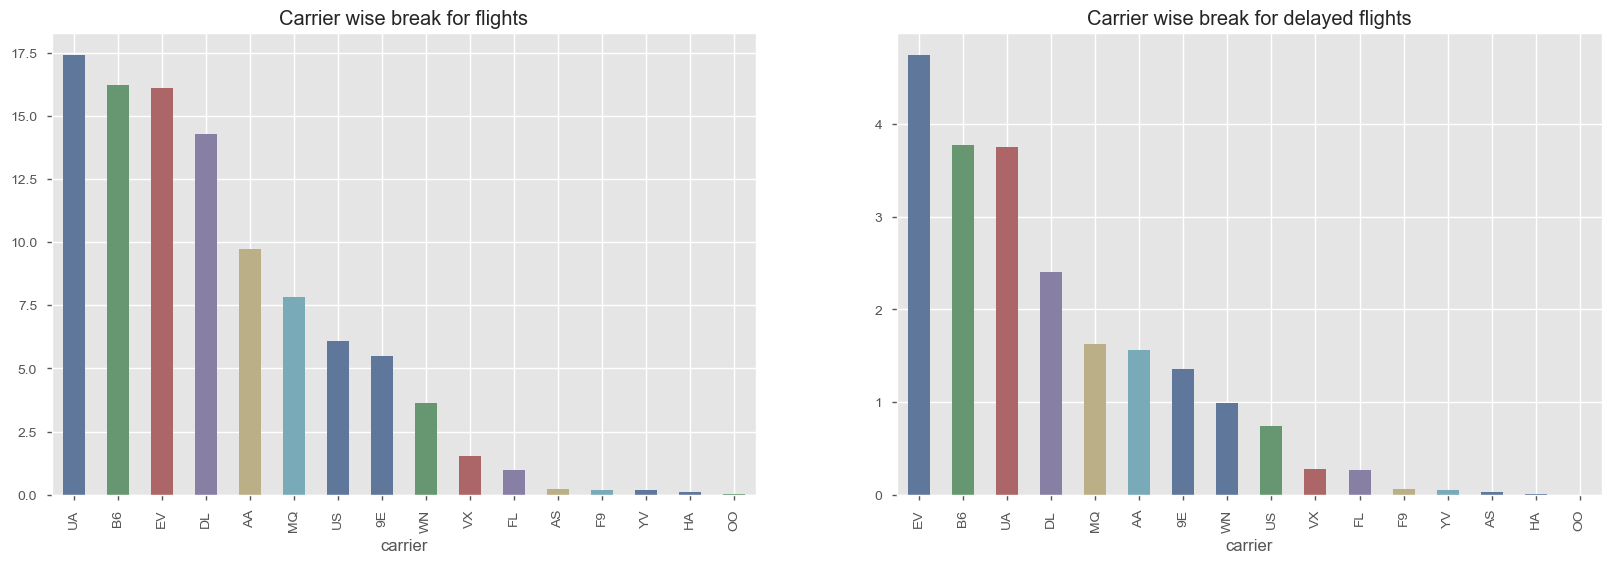

In [71]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,6))
plt.subplot(121)

pct_departure_carrier.sort_values(ascending=False).plot(kind='bar', title='Carrier wise break for flights')
plt.subplot(122)
pct_departure_carrier_delay_frmtotal.sort_values(ascending=False).plot(kind='bar', title='Carrier wise break for delayed flights')
plt.show();

Month wise analysis of departure delay

<Figure size 3000x200 with 0 Axes>

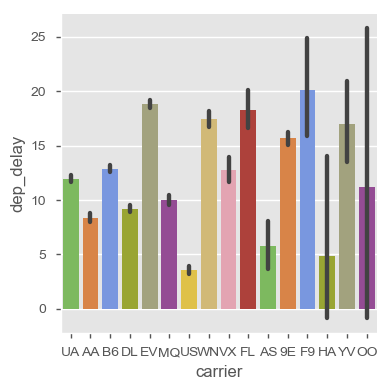

In [78]:
plt.figure(figsize=(30,2))
pkmn_type_colors = ['#78C850',  # WE
                    '#F08030',  # NA
                    '#6890F0',  # ANZ
                    '#A8B820',  # ME
                    '#A8A878',  # LA
                    '#A040A0',  # SA
                    '#F8D030',  # CEE
                    '#E0C068',  # EA
                    '#EE99AC',  # SSA
                    '#C03028',  # SA
                   ]
sns.factorplot(x='carrier', y='dep_delay', 
               data=flightdata,palette=pkmn_type_colors,kind='bar', label = 'dep_delay')
plt.show();

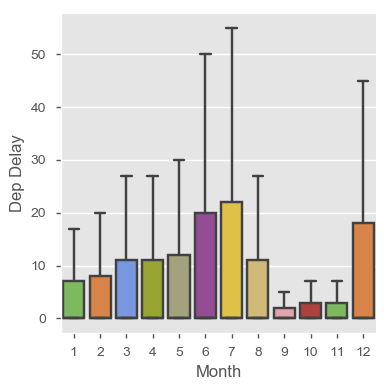

In [79]:
#Departure delay analysis of flights due to congestion at the airport, bad weather or less staffing
sns.factorplot(x='month',y='dep_del_new',
               data=flightdata,palette=pkmn_type_colors,kind='box', showfliers = False)
plt.xlabel("Month")
plt.ylabel("Dep Delay")
plt.show();

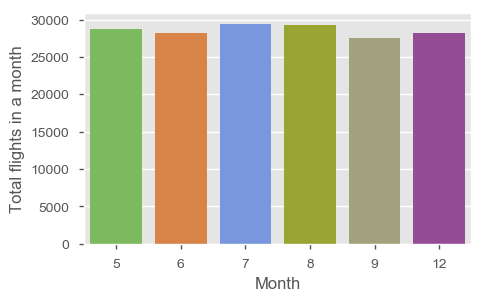

In [80]:
flight_month_data = flightdata.loc[flightdata['month'].isin([5,6,7,8,9,12])]
plt.figure(figsize=(5,3))
sns.countplot(x='month', data=flight_month_data, palette=pkmn_type_colors)
plt.xlabel("Month")
plt.ylabel("Total flights in a month")
plt.show();

In [81]:
origin_dummies = pd.get_dummies(flightdata['origin'],prefix='origin')
carrier_dummies = pd.get_dummies(flightdata['carrier'],prefix='carrier')

In [82]:
flightdata = pd.concat([flightdata,origin_dummies,carrier_dummies],axis=1)

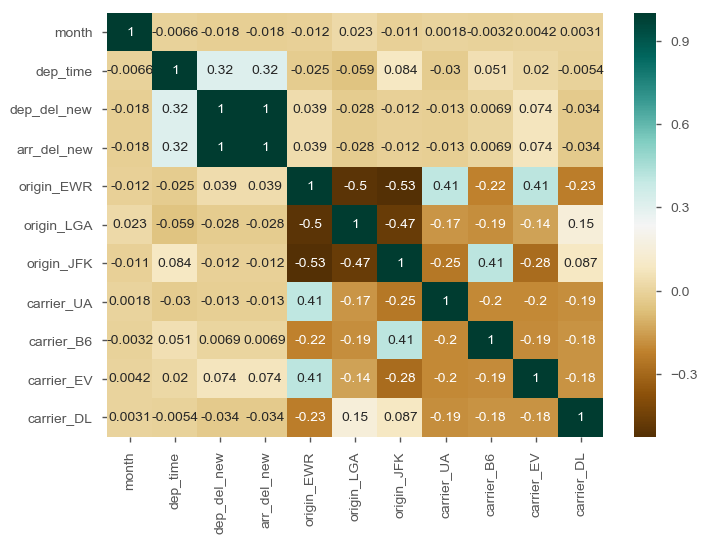

In [84]:
corr =flightdata[['month','dep_time','dep_del_new','arr_del_new','origin_EWR','origin_LGA','origin_JFK',
                   'carrier_UA','carrier_B6','carrier_EV','carrier_DL']].corr()
sns.heatmap(corr,cmap="BrBG",annot = True)
plt.show();

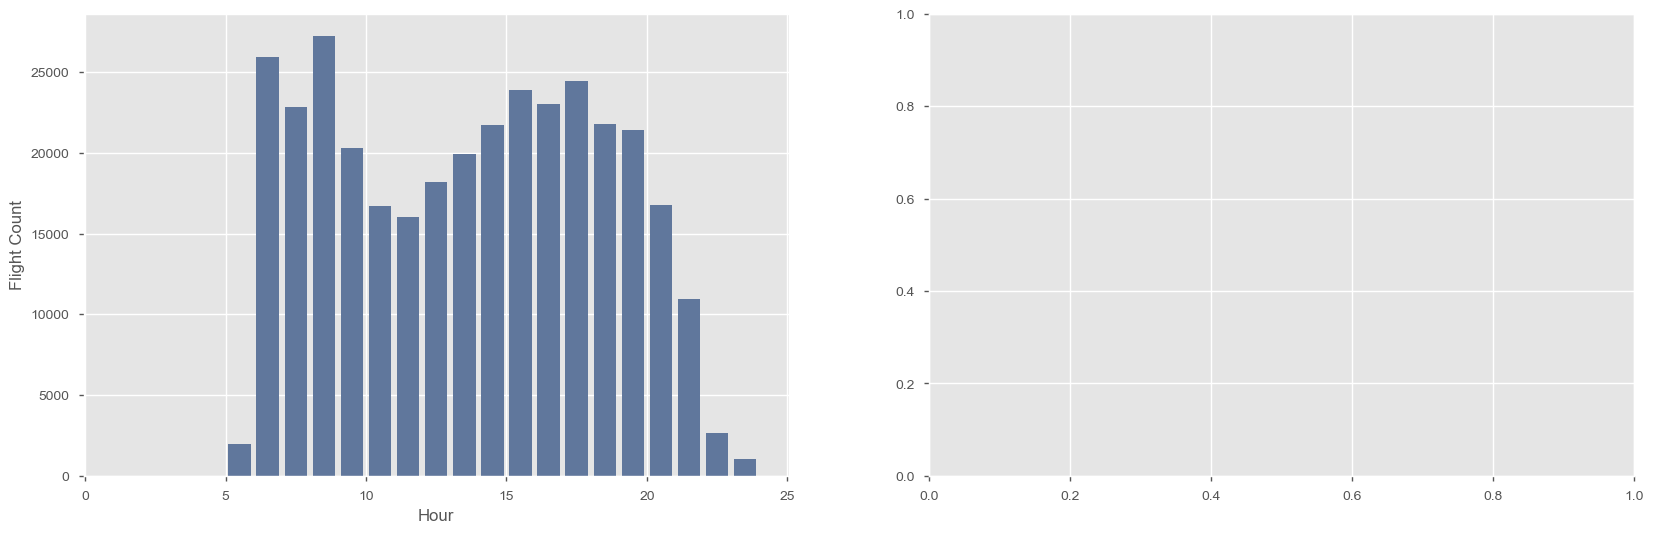

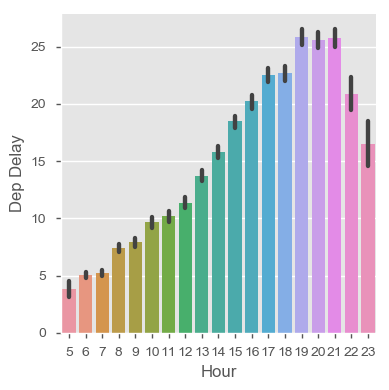

In [86]:
plt.figure(figsize=(20,6))
plt.subplot(121)

score = flightdata['hour']
bins = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
plt.hist(score, bins, histtype='bar', rwidth=0.8)
plt.xlabel('Hour')
plt.ylabel("Flight Count")
plt.subplot(122)
g= sns.factorplot(x='hour', y='dep_del_new',data=flightdata,kind='bar')
plt.xlabel("Hour")
plt.ylabel("Dep Delay")
plt.show();